In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import statsmodels.api as sm

In [2]:
# import dataset
dataset = pd.read_csv('airline_passengers.csv')

In [3]:
dataset.head()

,Month,Thousands of Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
dataset.shape

(144, 2)

In [5]:
dataset.tail()

,Month,Thousands of Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [6]:
from numpy import log
from datetime import datetime

In [7]:
dataset['Month'] = pd.to_datetime(dataset['Month'])

In [8]:
dataset.head()

,Month,Thousands of Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


#### In time series, make time as index value

In [9]:
dataset.set_index('Month',inplace=True)

In [10]:
dataset.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot:xlabel='Month'>

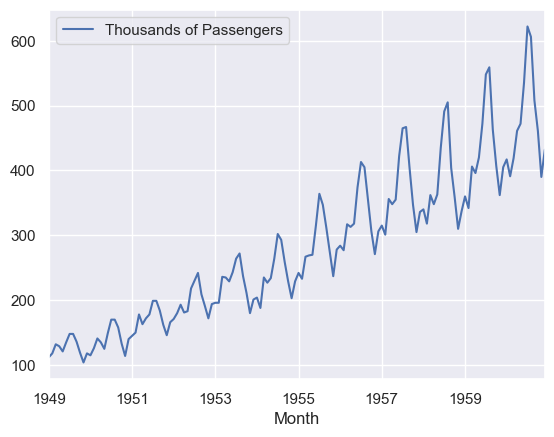

In [11]:
dataset.plot()

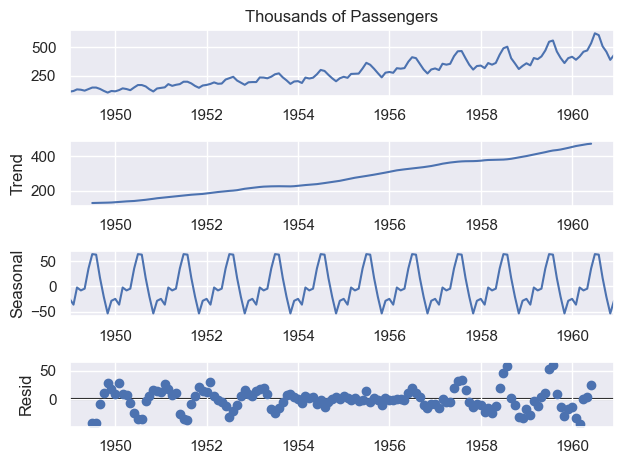

In [12]:
# Decomposition  methid to check dataset component

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset['Thousands of Passengers'],period = 12)
decomposition.plot()
plt.show()

##### Assumption for linear regression - data should not be autocorrelated- 
##### use durbin watson tes to check, it give value between 0 to 4, 
##### if dw = 2 (then no auto correlated),  
##### if dw = 0 to 1.99(+ve correlated)(autocorrelation found)
##### if dw = 2.01 to 4(-ve correlated)(autocorrelation found)

In [13]:
sm.stats.durbin_watson(dataset)
# yes, we found autocorrelation, hence we can reject our assumption for linear regression

array([0.0121528])

In [14]:
# note : if we don't have non stationary i.e already stationary time series data then we directly use "ARMA" model
# in case we have non stationary time series then first we make it stationary and then we will use
# "ARIMA" model

In [15]:
# Your time series data shpuld be "stationary"
# How will check -> using augmented Dickey fuller tes

from statsmodels.tsa.stattools import adfuller
adfuller(dataset['Thousands of Passengers'])

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

##### If p_value <= 0.05 then it is alternate hypothesis(Stationary value),confidence level will high
##### If p_value > 0.05 then it is null hypothesis(Non Stationary value),
(0.8153688792060482, wdf
 0.991880243437641,p-value
 13, Lag
 130, no. of observation
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [16]:
def adf_check(timeseries):
    result = adfuller(timeseries)
    print("Augmented Dickey Fuller Test")
    labels = ['ADF Test Statistics','p-value','#Lags','No. of Observation']
    
    for a,b in zip(result,labels):
        print(b + " : " + str(a))
    if result[1]<=0.05:
        print("Strong evidence against null hypothesis and my timeseries is Stationary")
    else:
        print("Weak evidence against null hyposthesis and my timeseries is non-stationary")
    

In [17]:
adf_check(dataset['Thousands of Passengers'])

Augmented Dickey Fuller Test
ADF Test Statistics : 0.8153688792060482
p-value : 0.991880243437641
#Lags : 13
No. of Observation : 130
Weak evidence against null hyposthesis and my timeseries is non-stationary


In [18]:
# in case we have non-stationary time series data then we have to make 
# it stationary by the help of lag function
dataset['1st Diff'] = dataset['Thousands of Passengers'] - dataset['Thousands of Passengers'].shift(1)

In [19]:
dataset

,Thousands of Passengers,1st Diff
Month,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0
...,...,...
1960-08-01,606,-16.0
1960-09-01,508,-98.0
1960-10-01,461,-47.0


In [20]:
adf_check(dataset['1st Diff'].dropna())

Augmented Dickey Fuller Test
ADF Test Statistics : -2.8292668241699994
p-value : 0.0542132902838255
#Lags : 12
No. of Observation : 130
Weak evidence against null hyposthesis and my timeseries is non-stationary


In [21]:
dataset['2nd Diff'] = dataset['1st Diff'] - dataset['1st Diff'].shift(1)

In [22]:
dataset

,Thousands of Passengers,1st Diff,2nd Diff
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0
...,...,...,...
1960-08-01,606,-16.0,-103.0
1960-09-01,508,-98.0,-82.0
1960-10-01,461,-47.0,51.0


In [23]:
adf_check(dataset['2nd Diff'].dropna())

Augmented Dickey Fuller Test
ADF Test Statistics : -16.384231542468505
p-value : 2.7328918500142407e-29
#Lags : 11
No. of Observation : 130
Strong evidence against null hypothesis and my timeseries is Stationary


In [24]:
# AIC = -2LL + 2K
# K = Parameter (pdq - Trend and PDQ - Seasonality)
# p/P - Partial autocorrelation (Auto Regressive method)
# d/D - Lag Difference(Integrated  method) - in case we have non - stationary data
# q/Q - AutoCorrelation (Moving Avg)
# Arima - AutoRegressive Integrated moving avg
# p = ?
# d = 2
# q = ?

# P = ?
# D = ?
# Q = ?

In [25]:
dataset['Seasonality'] = dataset['Thousands of Passengers'] - dataset['Thousands of Passengers'].shift(12)

In [26]:
dataset.head(20)

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN
1949-06-01,135,14.0,22.0,NaN
1949-07-01,148,13.0,-1.0,NaN
1949-08-01,148,0.0,-13.0,NaN
1949-09-01,136,-12.0,-12.0,NaN


In [27]:
adf_check(dataset['Seasonality'].dropna())

Augmented Dickey Fuller Test
ADF Test Statistics : -3.383020726492481
p-value : 0.011551493085514952
#Lags : 1
No. of Observation : 130
Strong evidence against null hypothesis and my timeseries is Stationary


In [28]:
# d = 2 (trend difference)
# D = 1 (seasonality difference)

# p/P and q/Q = ?
# p(Trend)/P(Seasonality) is calculated by AutoRegressive method (Partial Auto correlation)
# q(Trend)/Q(Seasonality) is calculated by Moving Avg (AutoCorrelation)

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

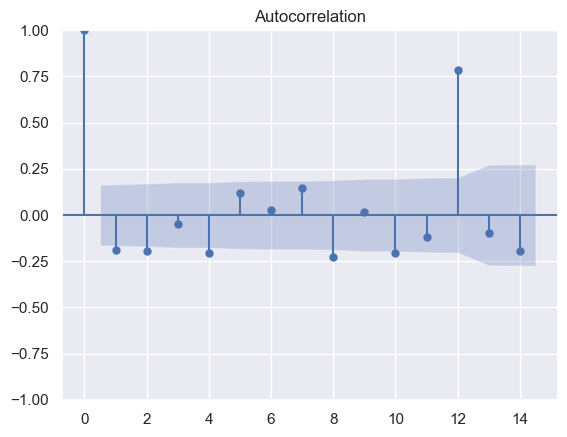

In [30]:
plot_acf(dataset['2nd Diff'].dropna(), lags=14)
plt.show()

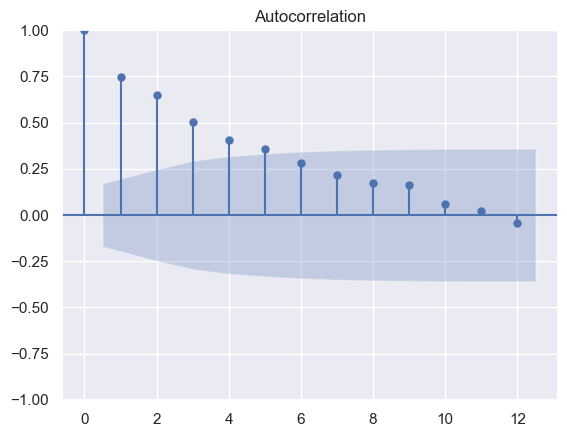

In [31]:
plot_acf(dataset['Seasonality'].dropna(), lags=12)
plt.show()

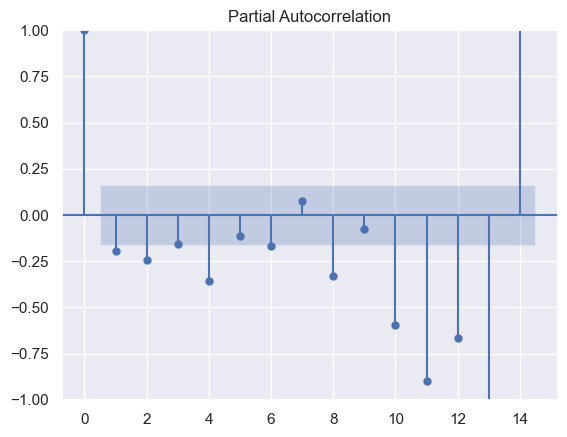

In [32]:
plot_pacf(dataset['2nd Diff'].dropna(), lags=14)
plt.show()

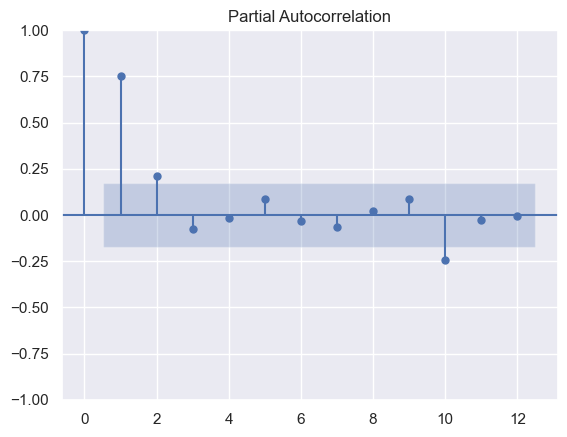

In [33]:
plot_pacf(dataset['Seasonality'].dropna(), lags=12)
plt.show()

In [34]:
# q(Trend)/Q(Seasonality) is calculated by Moving Avg (AutoCorrelation)

# Trend
# p - 4
# d - 2
# q(trend) - 2

# Seasonality
# P = 2
# D = 1
# Q = 5

## Building Time Series Forecasting basis ARIMA  Model

In [35]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [36]:
model =  sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'],
                                       order =(4, 2, 2), seasonal_order=(2, 1, 5, 12))

C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [37]:
result = model.fit()

C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
print(result.summary())

                                            SARIMAX Results                                             
Dep. Variable:                          Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1, 2, 3, 4, 5], 12)   Log Likelihood                -496.718
Date:                                          Tue, 11 Oct 2022   AIC                           1021.437
Time:                                                  19:49:13   BIC                           1061.582
Sample:                                              01-01-1949   HQIC                          1037.749
                                                   - 12-01-1960                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar

In [39]:
# [1, 2, 3, 4, 5]
# Q = 5, AIC = 1021.461
# Q = 4, AIC = 1020.041
# Q = 3, AIC = 1018.484 
# Q = 2, AIC = 1017.565
# Q = 1, AIC = 1015.567

In [40]:
model =  sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'],
                                       order =(4, 2, 2), seasonal_order=(2, 1, 1, 12))
result = model.fit()
print(result.summary())

C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:              Thousands of Passengers   No. Observations:                  144
Model:             SARIMAX(4, 2, 2)x(2, 1, [1], 12)   Log Likelihood                -497.781
Date:                              Tue, 11 Oct 2022   AIC                           1015.562
Time:                                      19:49:19   BIC                           1044.238
Sample:                                  01-01-1949   HQIC                          1027.214
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3592      0.097    -14.012      0.000      -1.549      -1.169
ar.L2         -0.49

In [41]:
# AutoArima Approach - iteration approach

In [42]:
import itertools
p = d = q = range(0,4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print("Check few parameter combination :")
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))

Check few parameter combination :
(0, 0, 1) x (0, 0, 1, 12)


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(dataset['Thousands of Passengers'],order = param, seasonal_order = param_seasonal,enforce_stationarity=False,enforce_invertibilty=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [43]:
# ARIMA(0,0,0)X(0,3,3,12) - AIC:697.8952307840076

In [44]:
# validate whether your model perform well or not

In [45]:
len(dataset)

144

In [46]:
dataset.head()

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality
Month,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN
1949-03-01,132,14.0,8.0,NaN
1949-04-01,129,-3.0,-17.0,NaN
1949-05-01,121,-8.0,-5.0,NaN


<AxesSubplot:xlabel='Month'>

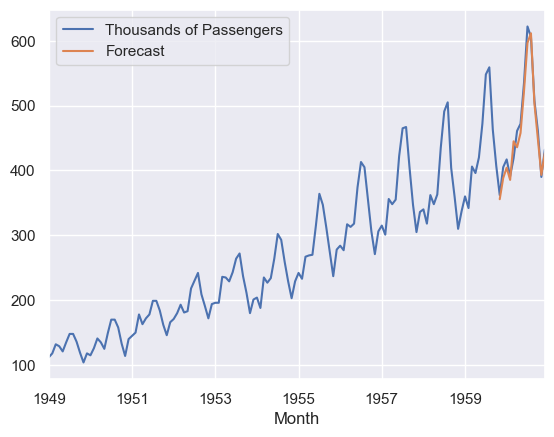

In [52]:
dataset['Forecast'] = result.predict(start=130,end=144,dynamic = True)
dataset[['Thousands of Passengers','Forecast']].plot()

In [53]:
# predict 5 years passengers details
# 1st jan 1961 to 1st Dec 1965

In [54]:
dataset.tail()

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality,Forecast
Month,,,,,
1960-08-01,606,-16.0,-103.0,47.0,611.526063
1960-09-01,508,-98.0,-82.0,45.0,503.462350
1960-10-01,461,-47.0,51.0,54.0,448.470562
1960-11-01,390,-71.0,-24.0,28.0,393.198881
1960-12-01,432,42.0,113.0,27.0,426.497158


In [56]:
from pandas.tseries.offsets import DateOffset

In [60]:
future_dates = [dataset.index[-1] + DateOffset(months=x) for x in range(0,61)]

In [61]:
future_dates

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [62]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns = dataset.columns)

In [63]:
future_dates_df.head()

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality,Forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN


In [64]:
future_df = pd.concat([dataset,future_dates_df])

In [65]:
future_df.head()

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality,Forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN


In [66]:
future_df.tail()

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality,Forecast
1965-08-01,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN
1965-12-01,NaN,NaN,NaN,NaN,NaN


C:\Users\ssaur\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:>

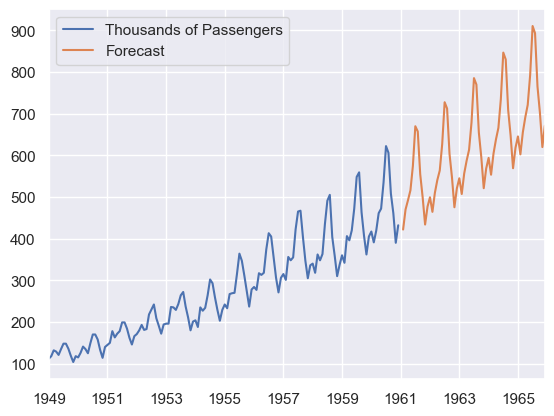

In [67]:
future_df['Forecast'] = result.predict(start=145,end =204,dynamic = True)
future_df[['Thousands of Passengers','Forecast']].plot()

In [68]:
future_df.tail(20)

,Thousands of Passengers,1st Diff,2nd Diff,Seasonality,Forecast
1964-05-01,NaN,NaN,NaN,NaN,665.710023
1964-06-01,NaN,NaN,NaN,NaN,734.626537
1964-07-01,NaN,NaN,NaN,NaN,846.358777
1964-08-01,NaN,NaN,NaN,NaN,829.853077
1964-09-01,NaN,NaN,NaN,NaN,708.353660
1964-10-01,NaN,NaN,NaN,NaN,647.359782
1964-11-01,NaN,NaN,NaN,NaN,568.886525
1964-12-01,NaN,NaN,NaN,NaN,618.056428
1965-01-01,NaN,NaN,NaN,NaN,645.187344
1965-02-01,NaN,NaN,NaN,NaN,602.126348
